In [1]:
import numpy as np
import matplotlib.pyplot as plt
from my_functions import *
%matplotlib notebook

In [2]:
pm_data = np.load('npy/pm_eLAE_1deg.npy')
f_name = 'Source_cats/Source_cat_LAE_1deg.npy'
mock = np.load( f_name, allow_pickle=True ).item()
errors = np.load('npy/errors5Sigma.npy')

In [3]:
filters_tags = load_filter_tags()
tcurves = load_tcurves(filters_tags)
w_central = np.array(central_wavelength(tcurves))

In [4]:
bb_fwhm = [
    nb_fwhm(tcurves, -4, True),
    nb_fwhm(tcurves, -3, True),
    nb_fwhm(tcurves, -2, True),
    nb_fwhm(tcurves, -1, True)
]

In [21]:
def nbex_cont_estimate(pm, nb_ind, mock_n): # Computes nb excess with linear estimation of the continuum
    cont_nb_Arr = [*range(nb_ind-5, nb_ind), *range(nb_ind+1, nb_ind+5+1)]
    cont_nb_Arr.sort()
    cont_nb_Arr = np.array(cont_nb_Arr)
    
    # Fitting
    x = w_central[cont_nb_Arr]
    y = pm[cont_nb_Arr]
    cont_fit = np.polyfit(x,y,1)

    ################# PLOT #################
    
    fig, ax = plt.subplots()
    ax.plot( mock['w_Arr'], mock['SEDs'][mock_n], c='orange', lw=2, zorder=-1)
    ax.scatter(w_central[:-3], pm[:-3])
    ax.errorbar(w_central[:-3], pm[:-3], yerr=errors[:-3, 1], fmt='none')
    ax.scatter(w_central[nb_ind], pm[nb_ind], c='black')
    
    ax.scatter(w_central[-4], pm[-4], c='purple' , marker='s')
    ax.scatter(w_central[-3], pm[-3], c='green'  , marker='s')
    ax.scatter(w_central[-2], pm[-2], c='red'    , marker='s')
    ax.scatter(w_central[-1], pm[-1], c='dimgray', marker='s')
    
    ax.errorbar(w_central[-4], pm[-4], xerr=bb_fwhm[-4]/2, fmt='none', color='purple' , elinewidth=4)
    ax.errorbar(w_central[-3], pm[-3], xerr=bb_fwhm[-3]/2, fmt='none', color='green'  , elinewidth=4)
    ax.errorbar(w_central[-2], pm[-2], xerr=bb_fwhm[-2]/2, fmt='none', color='red'    , elinewidth=4)
    ax.errorbar(w_central[-1], pm[-1], xerr=bb_fwhm[-1]/2, fmt='none', color='dimgray', elinewidth=4)
        
    ax.set_xlabel('$\lambda\ (\AA)$', size=15)
    ax.set_ylabel('$f_\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)', size=15)
    
    # Fit line
    x_fit = np.linspace(4000, 6000, 1000)
    y_fit = cont_fit[1] + cont_fit[0]*x_fit
    ax.plot(x_fit,y_fit, c='dimgray', linestyle='dashed')
    
    plt.show()
    
    ########################################

<IPython.core.display.Javascript object>


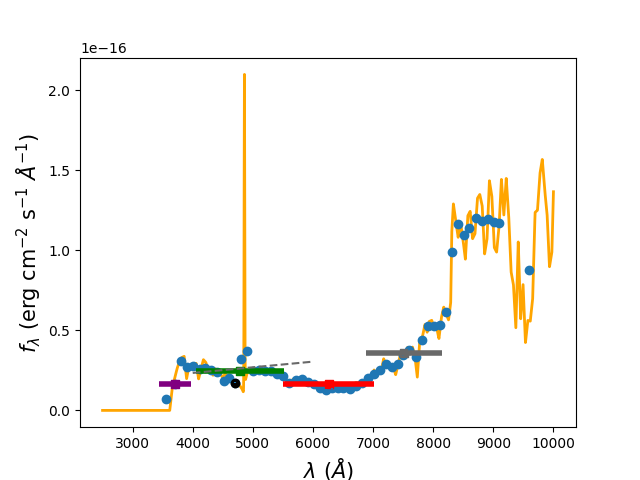

<IPython.core.display.Javascript object>


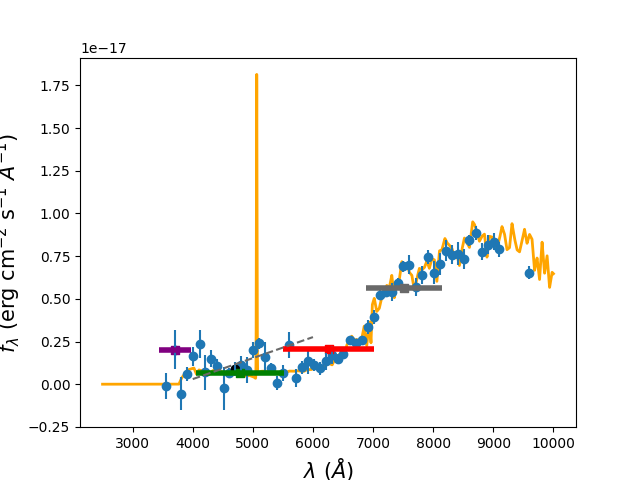

<IPython.core.display.Javascript object>


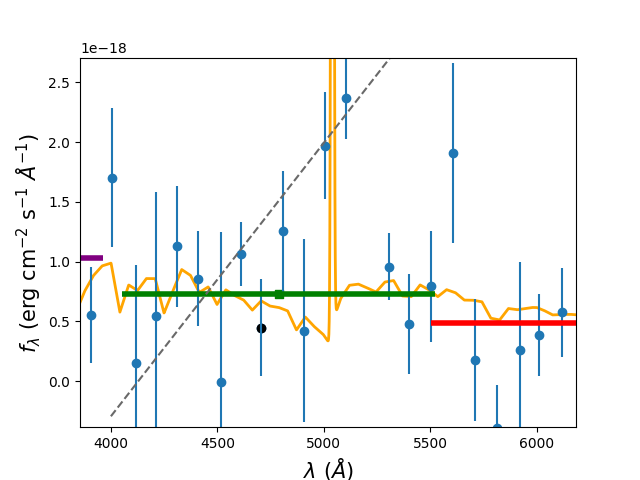

<IPython.core.display.Javascript object>


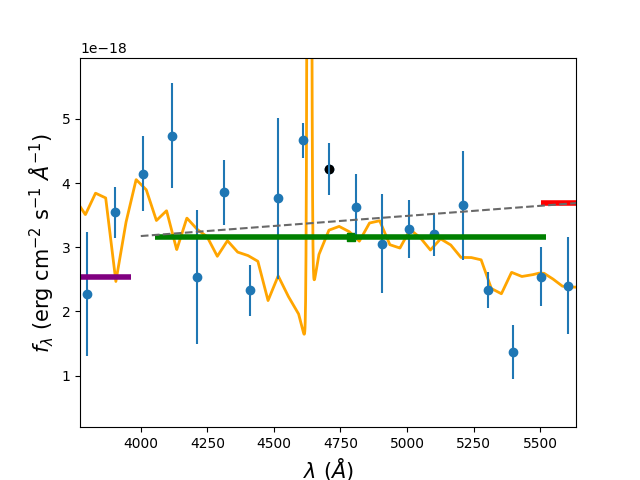

<IPython.core.display.Javascript object>


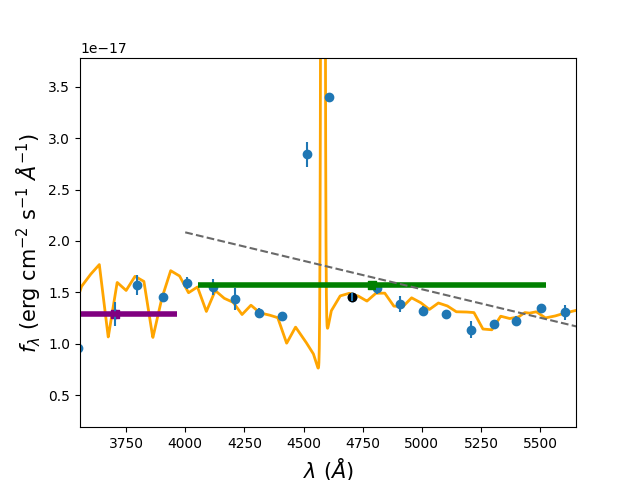

<IPython.core.display.Javascript object>


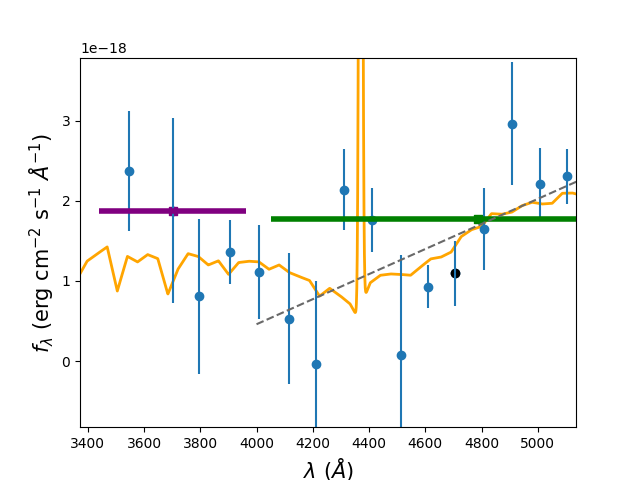

<IPython.core.display.Javascript object>


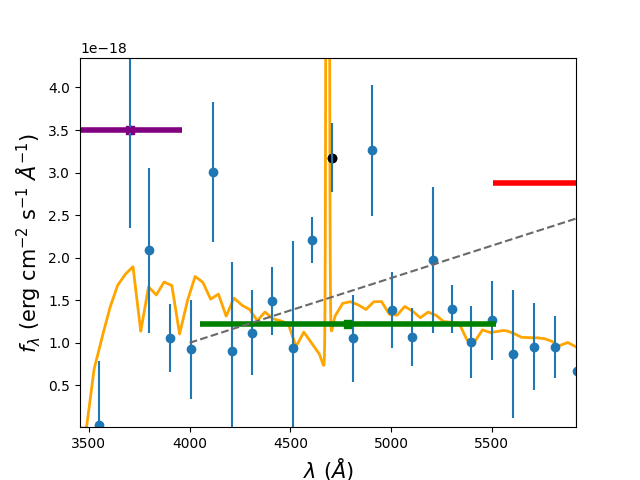

<IPython.core.display.Javascript object>


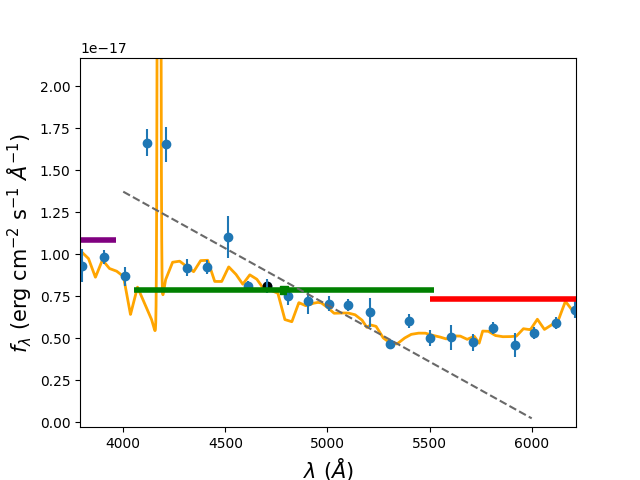

<IPython.core.display.Javascript object>


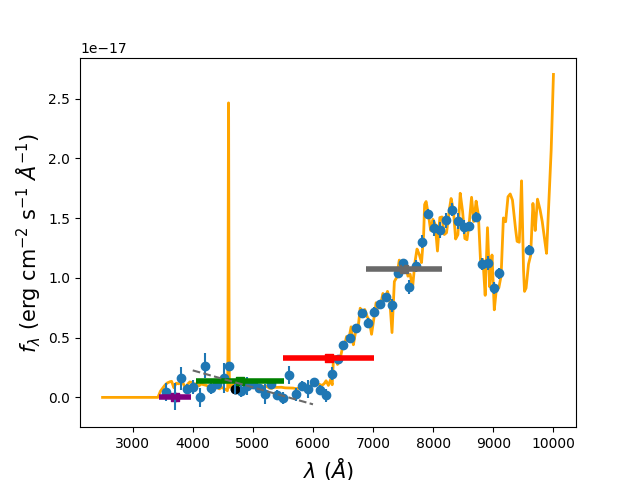

<IPython.core.display.Javascript object>


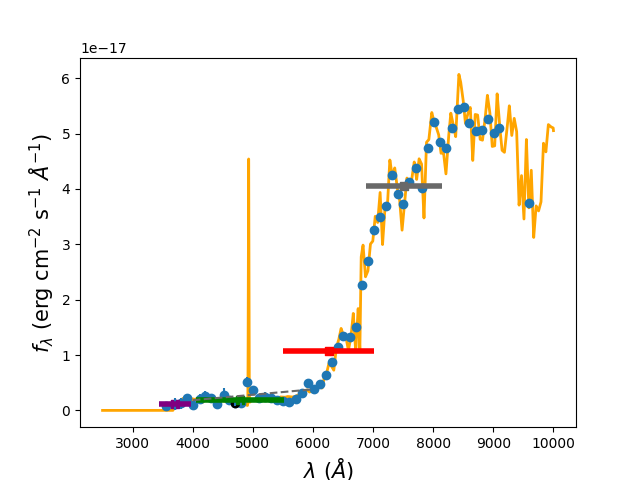

In [22]:
for mock_n in range(10):
    nbex_cont_estimate(pm_data[:,mock_n], 10, mock_n)